In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [ ]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [ ]:
import torch

# Create a sample tensor
x = torch.arange(10)  # Tensor of 10 elements (0 to 9)
print("x:", x)
# Split the tensor into 2 chunks along the 0th dimension (rows)
chunks = torch.chunk(x, chunks=2, dim=0)

# Print the chunks
print("Chunk 1:", chunks[0])
print("Chunk 2:", chunks[1])


x: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Chunk 1: tensor([0, 1, 2, 3, 4])
Chunk 2: tensor([5, 6, 7, 8, 9])


In [ ]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)

        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])

    def forward(self, x, t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std

In [ ]:
x = torch.randn((1000, 2))
model = MLP()
t = 5

mu, std = model(x, 5)
print(mu.shape)
print(std.shape)

torch.Size([1000, 2])
torch.Size([1000, 2])


In [ ]:
class DiffusionModel():

    def __init__(self, T, model: nn.Module, dim=2):

        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        self.T = T
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'

        t = t -1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)

        return mu + epsilon * std # data ~ N(mu, std)

    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)

        # print("mu:", mu.shape)
        # print("std:", std.shape)
        # print("epsilon:", epsilon.shape)

        return mu + epsilon * std # data ~ N(mu, std)


    def sample(self, batch_size):

        noise = torch.randn((batch_size, self.dim))
        x = noise

        samples = [x]
        for t in range(self.T, 0, -1):

            if not (t == 1):
                x = self.reverse_process(x, t)

            samples.append(x)

        return samples[::-1]

In [ ]:
x0 = sample_batch(3000)
print(x0.shape)
model_mlp = MLP()
model = DiffusionModel(40, model_mlp)
xT = model.forward_process(x0, 20)

torch.Size([3000, 2])


In [ ]:
samples = model.sample(1000)
print(samples[0].shape)

mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([1000, 2])
mu: torch.Size([1000, 2])
std: torch.Size([1000, 2])
epsilon: torch.Size([10

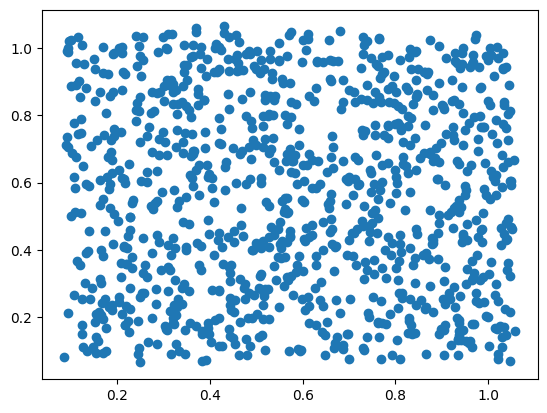

In [ ]:
t = 5
plt.scatter(samples[t][:, 0].data.numpy()
, samples[t][:, 1].data.numpy())